# Vehicle Detection using SVM

importing the required libraries and storing datasets in variables car_im and non_car_im

In [1]:
import glob
from sklearn.svm import SVC
from skimage.feature import hog
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
import time
import sklearn.svm
import numpy as np

car_im=glob.glob('./dataset/vehicles/*/*.png')
non_car_im=glob.glob('./dataset/non-vehicles/*/*.png')

print('Length of Car image is '+str(len(car_im))+' and Length of Non Car image is '+str(len(non_car_im)))

Length of Car image is 8792 and Length of Non Car image is 8968


In [2]:
def get_hog_features(img,orient,pix_per_cell,cell_per_block,vis=True,feature_vec=True):
    #if vis is True, then get both feature and image to display else get only features
    if vis == True:
        #getting hog_features by using the hog() function
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else: 
        #getting hog_features by using the hog() function
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

displaying hog features of one car image

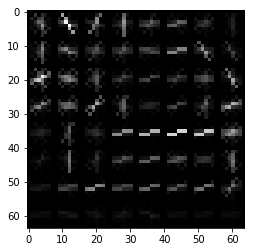

In [3]:
car_img=mpimg.imread(car_im[20])
#call function get_hog_features() to display a random image
abc,car_check=get_hog_features(car_img[:,:,2],9,8,8,vis=True,feature_vec=True)
plt.imshow(car_check,cmap='gray')
#plt.imshow(car_img)

displaying hog features of one non car image

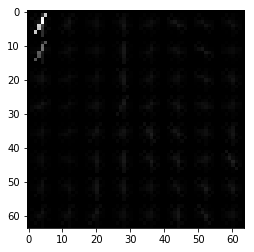

In [4]:
non_car_img=mpimg.imread(non_car_im[12])
#call function get_hog_features() to display a random image
abc,non_car_check=get_hog_features(non_car_img[:,:,2],9,8,8,vis=True,feature_vec=True)
plt.imshow(non_car_check,cmap='gray')

define bin_spatial() function to display spatial features of image

In [5]:
def bin_spatial(img, size=(32,32)):
    #resizing image and  flattening it
    features=cv2.resize(img,size).ravel()
    return features

define color_hist() function to get color histogram features of the image

In [6]:
def color_hist(img, nbins=32, bins_range=(0, 256)):
    #multiply the image by 255 in order to scale the image in range 0,255
    img=img*255
    # Compute the histogram of the color channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)#red features of image
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)#green features of image
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)#blue features of image
    # Concatenate the histograms into a single feature vector
    #hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    

    bin_edges=rhist[1]
    #calculating bin center
    bin_centers = (bin_edges[1:]+bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0],ghist[0],bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features
#feature_vec = color_hist(non_car_img, nbins=32, bins_range=(0, 256))


define a function extract_features() to get all the features of the image

In [7]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            #call the function bin_spatial() to get the spatial features of the image
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # call the function color_hist() to get color histogram features of the image
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

I selected the colorspace "YCrCb", orientation=16,pix_per_cell=16, cell_per_block=2, spatial_size= (16, 16) and hist_bins = 16

In [8]:
color_space = 'YCrCb' # I selected YCrCb colorspace
orient = 16  # After experimenting with various values, i took orientation as 16
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # This seem to give me better results comparatively
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off


car_features = extract_features(car_im, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(non_car_im, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)



In [9]:
#Vertically stack car and noncar features features and store them in X
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector and store in y
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

Define X_train, y_train, X_test, y_test

In [10]:
rand_state = np.random.randint(0, 100)
#I splitted my training set and test set in ratio 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)


In [11]:
from sklearn.preprocessing import StandardScaler
#normalize training set
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

In [12]:
print('Feature vector length is :=', len(X_train[0]))

Feature vector length is := 1392


In [13]:
#I chose rbf kernel as it was giving be better results
svc = SVC(kernel='rbf')
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC....')
# Check the score of the SVC
print('Test Accuracy of SVC is = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()



64.87 Seconds to train SVC....
Test Accuracy of SVC is =  0.9913


Here I define my slide_window() function which would slide through the regions of image which i have mentioned

In [14]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
     # By this i am taking the region where i need to scan with my window   
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))#pixel per step for x
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))#pixel per step for y
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to this
    window_list = []

    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position with the below formula
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows in the variable window_list
    return window_list

I took 3 sliding windows with size (64,64), (96,96) ad (128,128) to detect the vehicle and checked them on image stored in test_image

In [15]:
y_start_stop = [400, 656] # Min and max in y to search in slide_window()
x_start_stop=[710,None]
test1='./test_images/test5.jpg'

test_image=mpimg.imread(test1)
test_image=test_image.astype(np.float32)/255
windows_small = slide_window(test_image, x_start_stop=[790, None], y_start_stop=y_start_stop, 
                    xy_window=(64, 64), xy_overlap=(0.7, 0.7))
windows_medium = slide_window(test_image, x_start_stop=[790, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.7, 0.7))
windows_large = slide_window(test_image, x_start_stop=[790, None], y_start_stop=y_start_stop, 
                    xy_window=(128, 128), xy_overlap=(0.7, 0.7))


In [16]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image and store this in imcopy variable
    imcopy = np.copy(img)
    # Iterate through the bounding boxes and draw a rectangle
    for bbox in bboxes:
        # Draw a rectangle for the given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [17]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #  Define an empty list to receive features
    img_features = []
    #  Apply color conversion if colorpsace is different than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #  Compute spatial features if flag is set
    if spatial_feat == True:
        #call bin_spatial to extract spatial features of the image
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #  Append spatial features to the list
        img_features.append(spatial_features)
    #  Compute histogram features if flag is set(Take color_histogram features of the image)
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        # Append color_hostogram features to the list
        img_features.append(hist_features)
    #  Compute HOG features if flag is set(flag=='True')
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #  Append hog_features to list
        img_features.append(hog_features)

    #  Return img_features features
    return np.concatenate(img_features)

In [18]:
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    # Create an empty list 'on_windows' which will store the windows list whereever the car is detected
    on_windows = []
    # Iterate over all windows in the list
    for window in windows:
        # Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #) Extract features for that window by invoking single_img_features() function
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        # Scale extracted features to be fed to the classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        # Predict using classifier by calling the  clf.predict()
        prediction = clf.predict(test_features)
        # If  (prediction == 1) then save the window as it shows that car is detected in that window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

Here i defined function calculate_total_windows() which will return all the window list which detect cars in it irrespective of the window size

In [19]:

xy_overlap=(0.7, 0.7)
def calculate_total_windows(test_image1,x_start_stop,my_start_stop,xy_overlap,color_space,
                           spatial_size,hist_bins,orient,pix_per_cell,cell_per_block,hog_channel,spatial_feat
                           ,hist_feat,hog_feat):
    windows_small=slide_window(test_image1, x_start_stop=[790, None], y_start_stop=y_start_stop, 
                    xy_window=(64, 64), xy_overlap=(0.7, 0.7))
    windows_medium = slide_window(test_image1, x_start_stop=[790, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.7, 0.7))
    windows_large = slide_window(test_image1, x_start_stop=[790, None], y_start_stop=y_start_stop, 
                    xy_window=(128, 128), xy_overlap=(0.7, 0.7))
    #This is to caluclate positive windows by the small window(64,64)
    hot_windows_small = search_windows(test_image1, windows_small, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    #This is to caluclate positive windows by the medium sized window(96,96)
    hot_windows_medium = search_windows(test_image1, windows_medium, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    #This is to caluclate positive windows by the large size window(128,128)
    hot_windows_large = search_windows(test_image1, windows_large, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    hot_windows=hot_windows_small
    #Adding all the 3 sizes of windows to the single window
    hot_windows=hot_windows+hot_windows_medium+hot_windows_large
    
    return hot_windows

hot_windows_check=calculate_total_windows(test_image,x_start_stop,y_start_stop,xy_overlap,color_space,
                           spatial_size,hist_bins,orient,pix_per_cell,cell_per_block,hog_channel,spatial_feat
                           ,hist_feat,hog_feat)
    

Below is the same process i performed for my test_image

In [20]:
hot_windows_small = search_windows(test_image, windows_small, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

hot_windows_medium = search_windows(test_image, windows_medium, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

hot_windows_large = search_windows(test_image, windows_large, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

In [21]:
hot_windows=hot_windows_small
hot_windows=hot_windows+hot_windows_medium+hot_windows_large


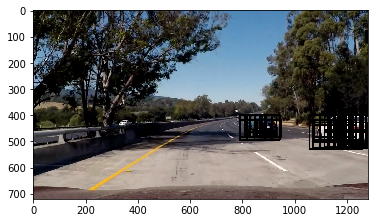

In [22]:
window_test_img_small=draw_boxes(test_image,hot_windows_small,color=(0, 0, 0), thick=6)
windows_test_img_medium=draw_boxes(window_test_img_small,hot_windows_medium,color=(0, 0, 0), thick=6)
windows_test_img_large=draw_boxes(windows_test_img_medium,hot_windows_large,color=(0, 0, 0), thick=6)
plt.imshow(windows_test_img_large)

Here I have defined Heat_map to reject the false positives on the basis of a threshold value and selecting only single window instead of multiple windows for a single car

In [23]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bbox_list
    for box in bbox_list:
        # Add += 1 for all pixels inside each box
        
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1#  each "box" takes the form ((x1, y1), (x2, y2))

    # Return heatmap
    return heatmap
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0#This would make the selected portion black
    # Return thresholded map(heatmap)
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the rectnagular box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the modified image
    return img

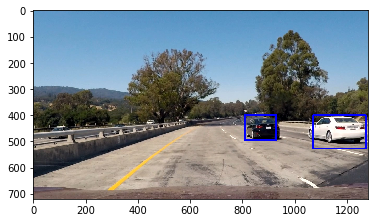

In [50]:
from scipy.ndimage.measurements import label
test1='./test_images/test1.jpg'
test_image=mpimg.imread(test1)
def display_final_image(heat_img,hot_windows):
    heat=np.zeros_like(heat_img[:,:,0]).astype(np.float)
    heat = add_heat(heat,hot_windows)
    heat = apply_threshold(heat,2)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(heat_img), labels)
    return draw_img
plt.imshow(display_final_image(test_image,hot_windows_check),cmap='hot')


Below is my pipeline which takes my image, calls the required function and returns the required image (Vehicles detected in it)

In [51]:

def pipeline_for_vehicle_detection(im1):
    im1=im1.astype(np.float32)/255    
    hot_windows_check=calculate_total_windows(im1,x_start_stop,y_start_stop,xy_overlap,color_space,
                           spatial_size,hist_bins,orient,pix_per_cell,cell_per_block,hog_channel,spatial_feat
                           ,hist_feat,hog_feat)
    final_image=display_final_image(im1,hot_windows_check)
    #print(final_image)
    #return final_image
    return final_image*255


    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


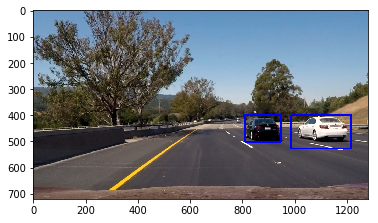

In [52]:
test1='./test_images/test6.jpg'
test_image=mpimg.imread(test1)

final_im=pipeline_for_vehicle_detection(test_image).astype(np.float32)
#print(final_im)
plt.imshow(final_im/255)


Displaying my pipeline for 6 provided test images

test_images/test1.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


test_images/test2.jpg
test_images/test3.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


test_images/test4.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


test_images/test5.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


test_images/test6.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


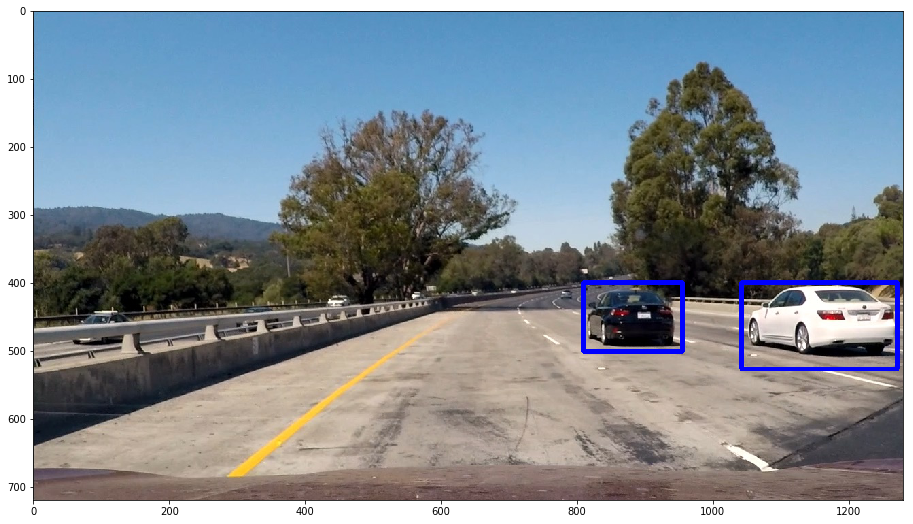

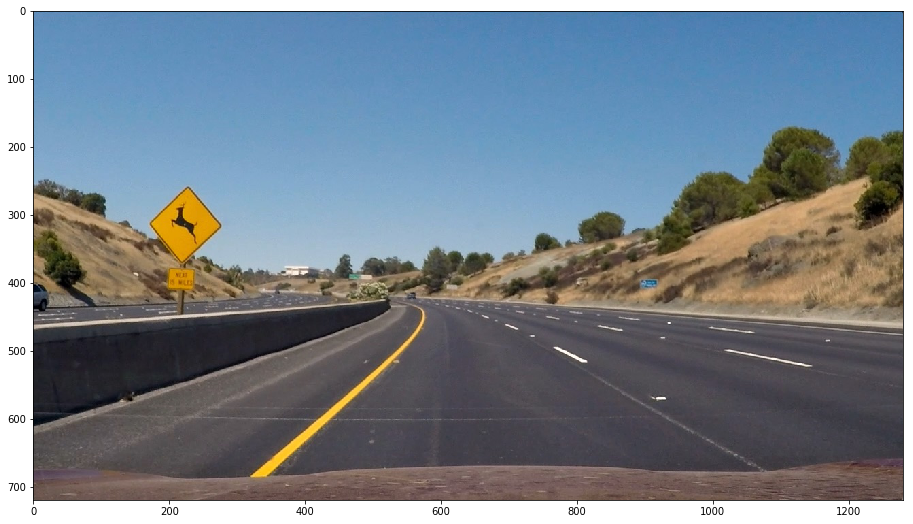

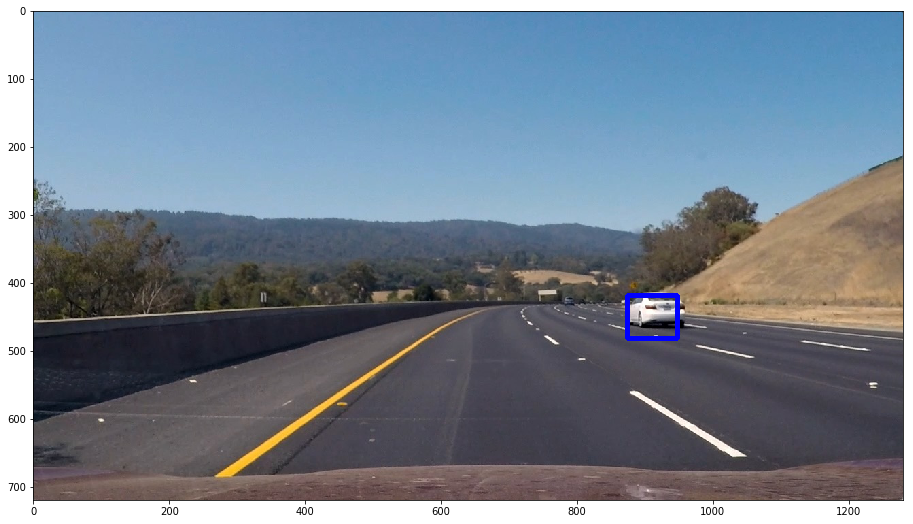

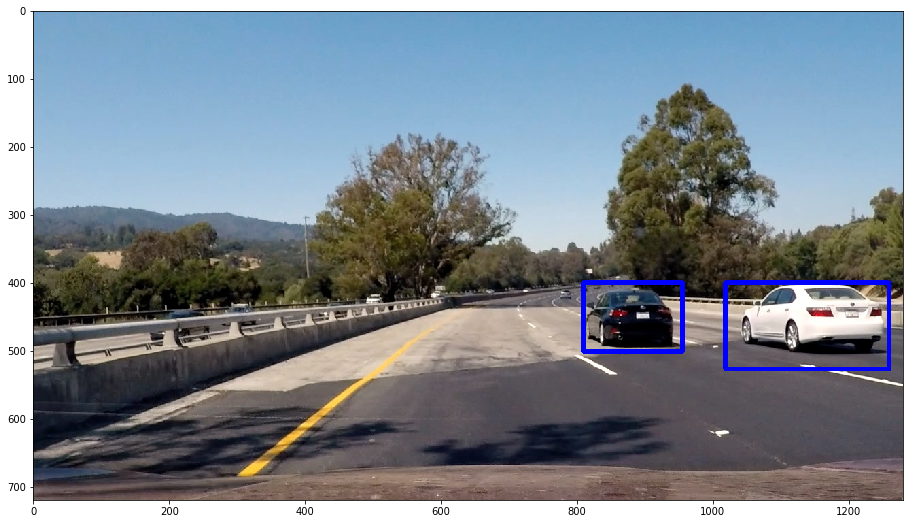

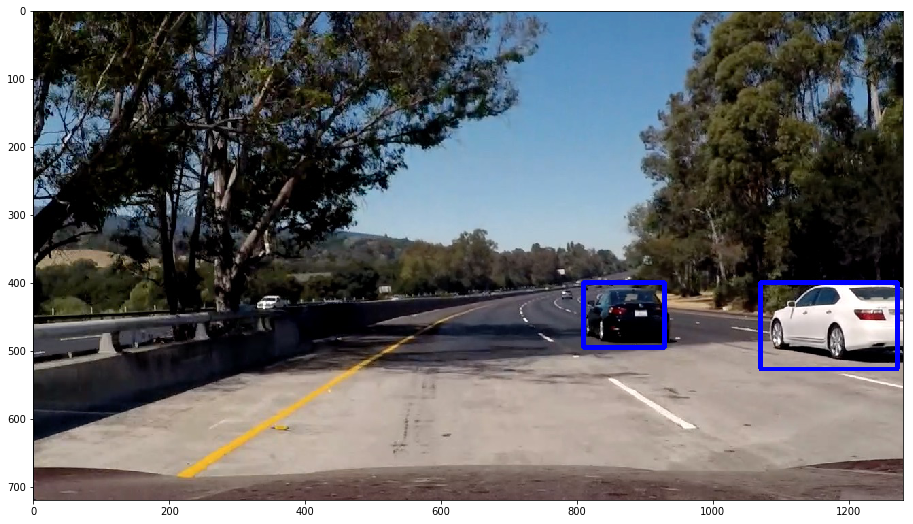

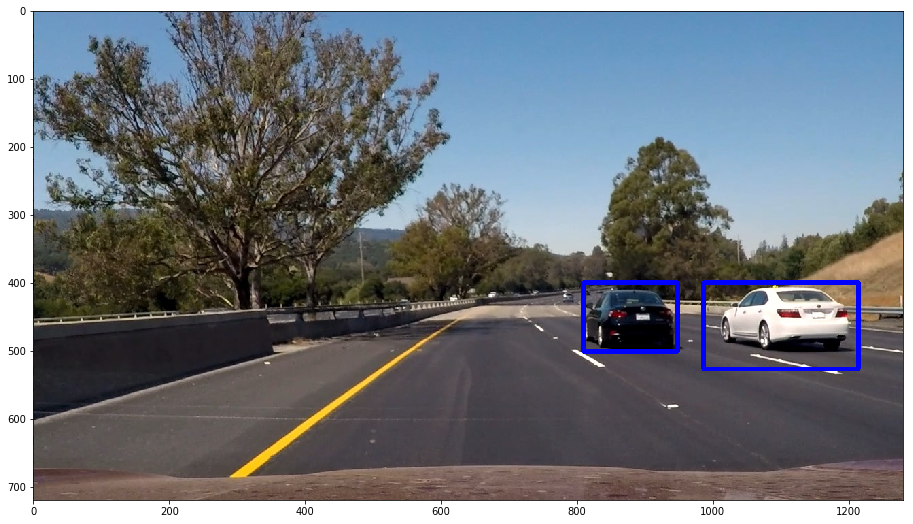

In [53]:
for i in range(1,7):
    img_name_test = 'test_images/test{}.jpg'.format(i)
    img = mpimg.imread(img_name_test)
    f, (ax1) = plt.subplots(1, 1, figsize=(18,9))
    print(img_name_test)
    ax1.imshow(pipeline_for_vehicle_detection(img)/255)

Generating Output Video for project_video.mp4

In [30]:
from moviepy.editor import VideoFileClip

white_output = './RBF/project_video_output_with_hog0_last_day.mp4'
clip = VideoFileClip("project_video.mp4")
white_clip = clip.fl_image(pipeline_for_vehicle_detection) 
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./RBF/project_video_output_with_hog0_last_day.mp4
[MoviePy] Writing video ./RBF/project_video_output_with_hog0_last_day.mp4



 11%|████████▍                                                                      | 135/1261 [05:49<48:26,  2.58s/it]


 21%|████████████████▉                                                              | 271/1261 [11:43<42:36,  2.58s/it]


 32%|█████████████████████████▍                                                     | 407/1261 [17:34<36:55,  2.59s/it]


 43%|██████████████████████████████████                                             | 543/1261 [23:29<31:14,  2.61s/it]


 54%|██████████████████████████████████████████▌                                    | 679/1261 [29:21<24:57,  2.57s/it]


 65%|███████████████████████████████████████████████████                            | 815/1261 [35:12<19:08,  2.58s/it]


 75%|███████████████████████████████████████████████████████████▌                   | 951/1261 [41:04<13:19,  2.58s/it]


 86%|███████████████████████████████████████████████████████████████████▏          | 1087/1261 [46:55<07:30,  2.59s/it]


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1223/1261 [52:46<01:37,  2.57s/it]


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [54:22<00:02,  2.57s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./RBF/project_video_output_with_hog0_last_day.mp4 

Wall time: 54min 24s


Generating Output video for test_video.mp4

In [54]:
from moviepy.editor import VideoFileClip

white_output = './RBF/test_output_video.mp4'
clip = VideoFileClip("test_video.mp4")
white_clip = clip.fl_image(pipeline_for_vehicle_detection) 
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./RBF/test_output_video.mp4
[MoviePy] Writing video ./RBF/test_output_video.mp4



 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [01:41<00:02,  2.78s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./RBF/test_output_video.mp4 

Wall time: 1min 44s
